<a href="https://colab.research.google.com/github/NLinh-Tran/Lending-Club/blob/main/Lending_Club_Loan_Portfolio_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **OVERVIEW**

A comprehensive analysis of Lending Club’s historical loan portfolio, uncovering how borrower behavior, credit risk, and loan performance have evolved over time and across segments.

By examining patterns in issuance, approvals, charge-offs, and borrower quality, the analysis highlights key trends and risk dynamics that shape portfolio outcomes and inform strategic understanding.

# **A. NOTEBOOK SETUP**

In [ ]:
import kagglehub
wordsforthewise_lending_club_path = kagglehub.dataset_download('wordsforthewise/lending-club')

print('Data source import complete.')

Data source import complete.


In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pandas as pd
import logging
import sys
import os
import matplotlib.pyplot as plt

print('Import Libraries')

Import Libraries


In [ ]:
spark = SparkSession.builder                                        \
                    .appName("LendingClubAnalysis")                 \
                    .config("spark.ui.showConsoleProgress","false") \
                    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

In [ ]:
accepted_df = spark.read.option("header", True)                                             \
                        .option("inferSchema", True)                                        \
                        .option("multiLine", True)                                          \
                        .option("escape", '"')                                              \
                        .csv("/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz")

rejected_df = spark.read.option("header", True)                                             \
                        .option("inferSchema", True)                                        \
                        .option("multiLine", True)                                          \
                        .option("escape", '"')                                              \
                        .csv("/kaggle/input/lending-club/rejected_2007_to_2018Q4.csv.gz")

# **B. LENDING CLUB DATASET OVERVIEW**

In [ ]:
print("Accepted Count:", accepted_df.count())
print("Rejected Count:", rejected_df.count())

Accepted Count: 2260701
Rejected Count: 27648741


In [ ]:
# 'issue_d' was stored in string format --> need to cast to date format

accepted_df.withColumn('issue_date', to_date(col('issue_d'), 'MMM-yyyy')) \
           .select(
                date_format(min('issue_date'), 'MMM-yyyy').alias('Earliest Issue Date'),
                date_format(max('issue_date'), 'MMM-yyyy').alias('Latest Issue Date')
            ).toPandas()

,Earliest Issue Date,Latest Issue Date
0,Jun-2007,Dec-2018


In [ ]:
# Total distinct id count
print("Unique IDs:", accepted_df.select('id').distinct().count())

# Total duplicate id count
print("Duplicates:", accepted_df.groupBy('id').count().filter(col('count')>1).count())

Unique IDs: 2260701
Duplicates: 0


# **C. BUILD DATASET**

In [ ]:
accepted_df_clean = accepted_df.dropna(subset=['earliest_cr_line' , 'loan_amnt', 'annual_inc']) \
                               .filter((col('dti') >= 0) &
                                       (col('dti') <= 100) &
                                       (col('revol_util') <= 100) &
                                       (col('total_acc') <= 48) &
                                       (col('open_acc') <= 22)) \
                               .withColumn('issue_d', to_date(col('issue_d'), 'MMM-yyyy')) \
                               .withColumn('earliest_cr_line', to_date(col('earliest_cr_line'), 'MMM-yyyy')) \
                               .withColumn('months_of_credit',
                                           round(months_between(col("issue_d"), col("earliest_cr_line"))).cast("int")) \
                               .filter(col('months_of_credit') <= 600) \
                               .withColumn('emp_length_years',
                                      when(col('emp_length') == '< 1 year', 0)
                                      .when(col('emp_length') == '1 year', 1)
                                      .when(col('emp_length') == '2 years', 2)
                                      .when(col('emp_length') == '3 years', 3)
                                      .when(col('emp_length') == '4 years', 4)
                                      .when(col('emp_length') == '5 years', 5)
                                      .when(col('emp_length') == '6 years', 6)
                                      .when(col('emp_length') == '7 years', 7)
                                      .when(col('emp_length') == '8 years', 8)
                                      .when(col('emp_length') == '9 years', 9)
                                      .when(col('emp_length') == '10+ years', 10)
                                      .when(col('emp_length').isNull(), -1))

# **D. LOAN PORTFOLIO ANALYSIS**

## **1. Loan Issuance**

### a. Over Time

In [ ]:
# Loan Issuance Over Time

issued = accepted_df_clean \
                              .select(
                                    year(col('issue_d')).alias('Year')
                                  ) \
                              .groupBy('Year') \
                              .count() \
                              .orderBy('Year') \
                              .dropna(subset=['Year']) \
                              .toPandas()

issued_sorted = issued.sort_values(by=['Year'])
issued_sorted['Year'] = issued_sorted['Year'].astype(int)
issued_sorted

,Year,count
0,2007,541
1,2008,2252
2,2009,5080
3,2010,12056
4,2011,21046
5,2012,51376
6,2013,127910
7,2014,218081
8,2015,386345
9,2016,400316


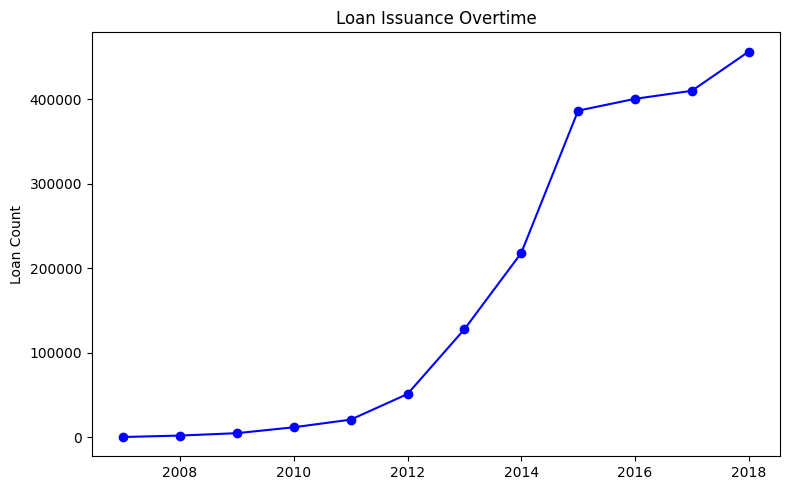

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(issued_sorted['Year'], issued_sorted['count'], marker='o', linestyle='-', color='blue')

plt.title('Loan Issuance Overtime')
plt.ylabel('Loan Count')
plt.tight_layout()
plt.show()

### b. By Vintages

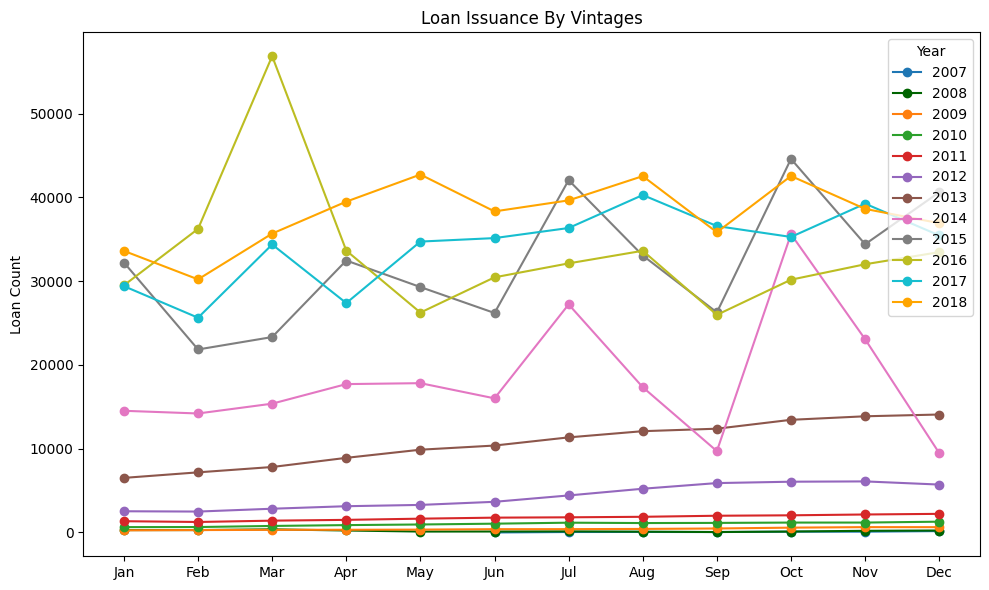

In [ ]:
# Loan Issuance By Vintages

issuance = accepted_df_clean \
                      .select(
                            date_format(col('issue_d'), 'MMM').alias('Month'),
                            year(col('issue_d')).alias('Year')
                             ) \
                      .groupBy('Year', 'Month') \
                      .count() \
                      .orderBy('Year', 'Month') \
                      .dropna(subset=['Year', 'Month']) \
                      .toPandas()

month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun','Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
issuance['Month'] = pd.Categorical(issuance['Month'], categories=month_order, ordered=True)
issuance_sorted = issuance.sort_values(by=['Year', 'Month'])

pivot_df = issuance_sorted.pivot(index='Month', columns='Year', values='count').reindex(month_order)

plt.figure(figsize=(10, 6))

custom_colors = {
    2008: 'darkgreen',
    2018: 'orange'
}
for yr in pivot_df.columns:
    color = custom_colors.get(yr, None)
    plt.plot(
        pivot_df.index,
        pivot_df[yr],
        marker='o',
        linestyle='-',
        label=str(yr),
        color=color
    )

plt.title('Loan Issuance By Vintages')
plt.ylabel('Loan Count')
plt.legend(title='Year')
plt.xticks(ticks=range(len(month_order)), labels=month_order)
plt.tight_layout()
plt.show()

### c. Growth Rate, Issued Amount Over Time

In [ ]:
# Growth Rate

from pyspark.sql.window import Window

issued_yearly_agg = accepted_df_clean \
                              .withColumn('Year', year(col('issue_d')).alias('Year')) \
                              .groupBy('Year') \
                              .agg(count("*").alias("loan_issued_volume"),
                                   sum('loan_amnt').alias("loan_amnt_issued")) \
                              .orderBy('Year')

# Calculate previous year
window_spec = Window.orderBy("year")

issued_yearly_agg = issued_yearly_agg.withColumn("prev_loan_issued_volume", lag("loan_issued_volume").over(window_spec)) \
                                     .withColumn("prev_loan_amnt_issued", lag("loan_amnt_issued").over(window_spec))

# Calculate YoY growth rate
issued_yearly_agg = issued_yearly_agg.withColumn("YoY_growth_rate",
                                   when(col("prev_loan_issued_volume").isNotNull(),
                                   ((col("loan_issued_volume") - col("prev_loan_issued_volume")) / col("prev_loan_issued_volume")) * 100).otherwise(None)) \
                       .withColumn("YoY_loan_amnt_growth_rate",
                                   when(col("prev_loan_amnt_issued").isNotNull(),
                                   ((col("loan_amnt_issued") - col("prev_loan_amnt_issued")) / col("prev_loan_amnt_issued")) * 100).otherwise(None))

issued_yearly_agg = issued_yearly_agg.withColumn("YoY_growth_rate", round("YoY_growth_rate", 2)) \
                       .withColumn("YoY_loan_amnt_growth_rate", round("YoY_loan_amnt_growth_rate", 2)) \
                       .select('Year', 'loan_issued_volume', 'YoY_growth_rate',
                                       'loan_amnt_issued', 'YoY_loan_amnt_growth_rate') \
                       .orderBy('Year')

issued_yearly_agg_pd = issued_yearly_agg.toPandas()
issued_yearly_agg_pd

,Year,loan_issued_volume,YoY_growth_rate,loan_amnt_issued,YoY_loan_amnt_growth_rate
0,2007,541,NaN,4.504900e+06,NaN
1,2008,2252,316.27,1.965278e+07,336.25
2,2009,5080,125.58,4.956508e+07,152.20
3,2010,12056,137.32,1.259989e+08,154.21
4,2011,21046,74.57,2.519500e+08,99.96
5,2012,51376,144.11,6.865618e+08,172.50
6,2013,127910,148.97,1.865084e+09,171.66
7,2014,218081,70.50,3.202514e+09,71.71
8,2015,386345,77.16,5.805047e+09,81.27
9,2016,400316,3.62,5.811421e+09,0.11


## **2. Charge-Off**

### a. Over Time

In [ ]:
# Charge-Off Over Time

chargeoff = accepted_df_clean \
                       .select(
                                year(col('issue_d')).alias('Year')
                              ) \
                       .filter(col('loan_status').isin(['Charged Off', 'Does not meet the credit policy. Status:Charged Off'])) \
                       .groupBy('Year') \
                       .count() \
                       .orderBy('Year') \
                       .dropna(subset=['Year']) \
                       .toPandas()
chargeoff

,Year,count
0,2007,139
1,2008,455
2,2009,697
3,2010,1687
4,2011,3206
5,2012,8326
6,2013,19941
7,2014,37774
8,2015,68701
9,2016,62235


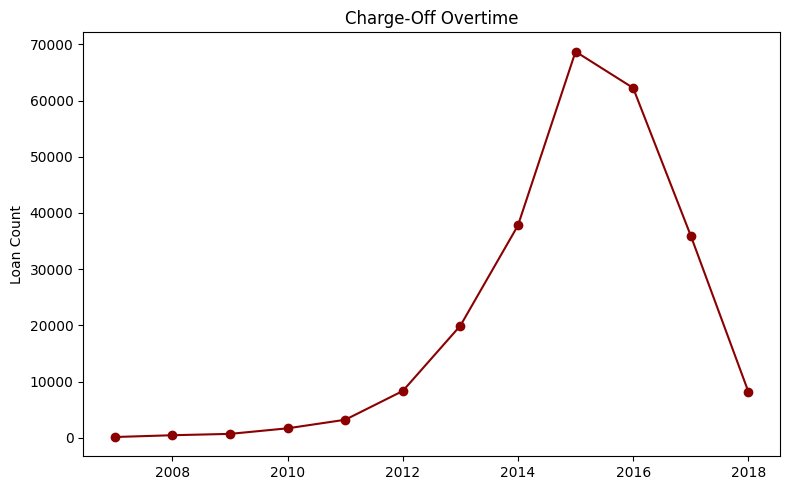

In [ ]:
chargeoff = chargeoff.sort_values(by=['Year'])
chargeoff['Year'] = chargeoff['Year'].astype(int)

plt.figure(figsize=(8, 5))

plt.plot(
    chargeoff['Year'],
    chargeoff['count'],
    marker='o',
    linestyle='-',
    color='darkred'
)

plt.title('Charge-Off Overtime')
plt.ylabel('Loan Count')
plt.tight_layout()
plt.show()


### b. Charge-Off Rate, Charge_Off Amount Over Time

In [ ]:
# Charge-Off Rate

from pyspark.sql.window import Window

yearly_agg = accepted_df_clean \
                              .withColumn('Year', year(col('issue_d')).alias('Year')) \
                              .filter(col('loan_status').isin(['Charged Off', 'Does not meet the credit policy. Status:Charged Off'])) \
                              .groupBy('Year') \
                              .agg(count("*").alias("CO_loans"),
                                   sum('loan_amnt').alias("CO_loan_amnt")) \
                              .orderBy('Year')

# Calculate previous year's charge-off
window_spec = Window.orderBy("year")

yearly_agg = yearly_agg.withColumn("prev_CO_loan_volume", lag("CO_loans").over(window_spec)) \
                       .withColumn("prev_CO_loan_amnt", lag("CO_loan_amnt").over(window_spec))

# Calculate YoY rate
yearly_agg = yearly_agg.withColumn("YoY_CO_rate",
                                   when(col("prev_CO_loan_volume").isNotNull(),
                                   ((col("CO_loans") - col("prev_CO_loan_volume")) / col("prev_CO_loan_volume")) * 100).otherwise(None)) \
                       .withColumn("YoY_CO_loan_amnt_rate",
                                   when(col("prev_CO_loan_amnt").isNotNull(),
                                   ((col("CO_loan_amnt") - col("prev_CO_loan_amnt")) / col("prev_CO_loan_amnt")) * 100).otherwise(None))

yearly_agg = yearly_agg.withColumn("YoY_CO_rate", round("YoY_CO_rate", 2)) \
                       .withColumn("YoY_CO_loan_amnt_rate", round("YoY_CO_loan_amnt_rate", 2)) \
                       .select('Year', 'CO_loans',  'YoY_CO_rate',
                                       'CO_loan_amnt', 'YoY_CO_loan_amnt_rate') \
                       .orderBy('Year')

CO_yearly_agg = yearly_agg.toPandas()
CO_yearly_agg

,Year,CO_loans,YoY_CO_rate,CO_loan_amnt,YoY_CO_loan_amnt_rate
0,2007,139,NaN,1.305175e+06,NaN
1,2008,455,227.34,4.516300e+06,246.03
2,2009,697,53.19,7.299925e+06,61.64
3,2010,1687,142.04,1.778402e+07,143.62
4,2011,3206,90.04,4.195390e+07,135.91
5,2012,8326,159.70,1.217124e+08,190.11
6,2013,19941,139.50,3.090948e+08,153.95
7,2014,37774,89.43,5.806948e+08,87.87
8,2015,68701,81.87,1.062993e+09,83.06
9,2016,62235,-9.41,9.436389e+08,-11.23


## **3. Approval Rate**

### a. Combined Dataset

In [ ]:
# Build combined dataset of approved and rejected applications

# Approved
accepted_combined = accepted_df.dropna(subset=['earliest_cr_line' , 'loan_amnt', 'annual_inc']) \
                               .withColumn('accepted_flag', lit(1)) \
                               .filter((col('dti') >= 0) &
                                       (col('dti') <= 100) &
                                       (col('revol_util') <= 100) &
                                       (col('total_acc') <= 48) &
                                       (col('open_acc') <= 22)) \
                               .withColumn('issue_d', to_date(col('issue_d'), 'MMM-yyyy')) \
                               .withColumn('earliest_cr_line', to_date(col('earliest_cr_line'), 'MMM-yyyy')) \
                               .withColumn('months_of_credit',
                                           round(months_between(col("issue_d"), col("earliest_cr_line"))).cast("int")) \
                               .filter(col('months_of_credit') <= 600) \
                               .withColumnRenamed('issue_d', 'time') \
                               .select('loan_amnt', 'emp_length', 'dti', 'addr_state', 'accepted_flag', 'time')

# Rejected
rejected_combined = rejected_df.withColumnRenamed('Amount Requested', 'loan_amnt') \
                        .withColumnRenamed('Employment Length', 'emp_length') \
                        .withColumnRenamed('State', 'addr_state') \
                        .withColumnRenamed('Policy Code', 'policy_code') \
                        .withColumn('dti', regexp_replace(col('Debt-To-Income Ratio'), '%', '').cast('double')) \
                        .filter((col('dti') >= 0) & (col('dti') <= 100)) \
                        .withColumn('accepted_flag', lit(0)) \
                        .withColumnRenamed('Application Date', 'time') \
                        .select('loan_amnt', 'emp_length', 'dti', 'addr_state', 'accepted_flag', 'time')

# Combined
combined = accepted_combined.union(rejected_combined)

combined = combined.withColumn('emp_length_years',
                       when(col('emp_length') == '< 1 year', 0)
                       .when(col('emp_length') == '1 year', 1)
                       .when(col('emp_length') == '2 years', 2)
                       .when(col('emp_length') == '3 years', 3)
                       .when(col('emp_length') == '4 years', 4)
                       .when(col('emp_length') == '5 years', 5)
                       .when(col('emp_length') == '6 years', 6)
                       .when(col('emp_length') == '7 years', 7)
                       .when(col('emp_length') == '8 years', 8)
                       .when(col('emp_length') == '9 years', 9)
                       .when(col('emp_length') == '10+ years', 10)
                       .when(col('emp_length').isNull(), -1)
                       .otherwise(-1))

combined = combined.drop('emp_length')

# Drop'loan_amnt', 'dti', 'addr_state' Null values
combined = combined.dropna(subset = ['loan_amnt', 'dti', 'addr_state'])

### b. Approval Rate Over Time

In [ ]:
# Approval Rate Over Time

rate = combined.withColumn('Year', year(col('time')).alias('Year')) \
        .groupBy('Year', 'accepted_flag') \
        .count() \
        .groupBy('Year') \
        .pivot('accepted_flag') \
        .sum('count') \
        .withColumn('approval rate', round((col('1') / (col('1') + col('0'))) * 100, 2)) \
        .orderBy('Year') \
        .toPandas()
rate

,Year,0,1,approval rate
0,2007,5169,541,9.47
1,2008,22887,2252,8.96
2,2009,48667,5080,9.45
3,2010,106183,12056,10.20
4,2011,205456,21046,9.29
5,2012,326166,51376,13.61
6,2013,731387,127910,14.89
7,2014,1645497,218081,11.70
8,2015,2537647,386345,13.21
9,2016,4326687,400316,8.47


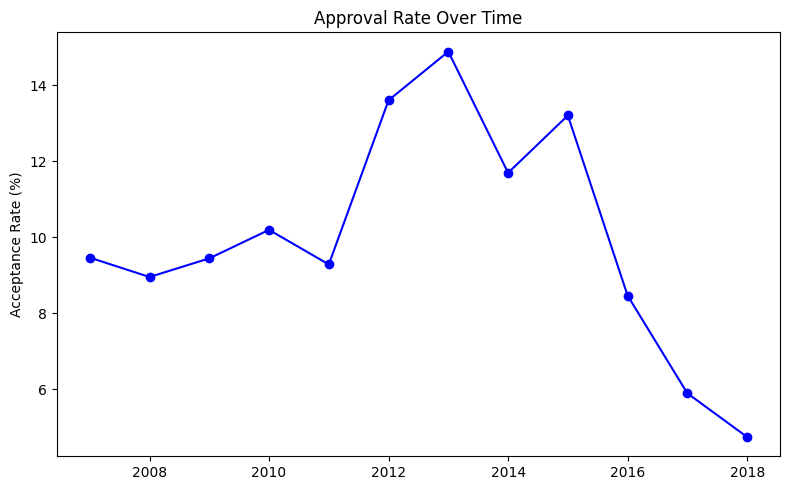

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(rate['Year'],
         rate['approval rate'],
         marker='o',
         linestyle='-',
         color='blue')
plt.title('Approval Rate Over Time')
plt.ylabel('Acceptance Rate (%)')
plt.tight_layout()
plt.show()

### c. Application Volume Over Time

In [ ]:
# Application Volume Over Time

vol = combined.withColumn('Year', year(col('time')).alias('Year')) \
        .groupBy('Year') \
        .count() \
        .orderBy('Year') \
        .toPandas()
vol

,Year,count
0,2007,5710
1,2008,25139
2,2009,53747
3,2010,118239
4,2011,226502
5,2012,377542
6,2013,859297
7,2014,1863578
8,2015,2923992
9,2016,4727003


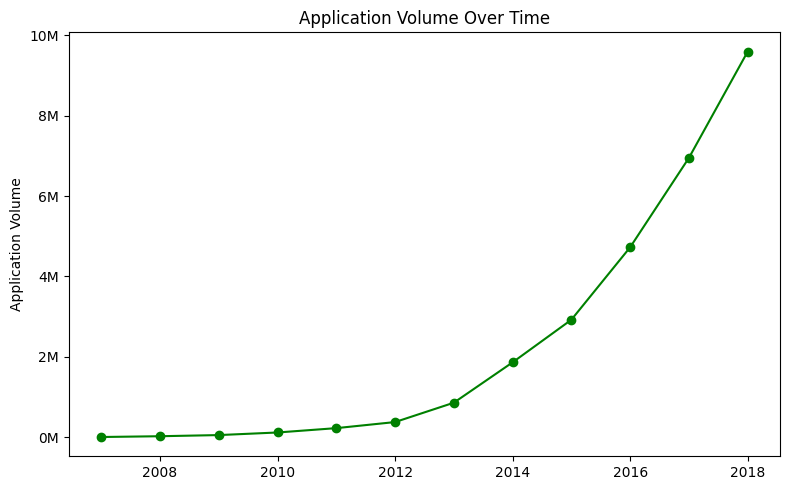

In [ ]:
import matplotlib.ticker as mtick

plt.figure(figsize=(8, 5))
plt.plot(vol['Year'],
         vol['count'],
         marker='o',
         linestyle='-',
         color='green')
plt.title('Application Volume Over Time')
plt.ylabel('Application Volume')
plt.gca().yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f'{x*1e-6:.0f}M'))
plt.tight_layout()
plt.show()

### d. Approval Rate & Application Volume by Employment Length

In [ ]:
# Approval Rate by Employment Length

approval_by_emp_length = combined.groupBy("emp_length_years", "accepted_flag") \
                                    .count() \
                                    .groupBy("emp_length_years") \
                                    .pivot("accepted_flag") \
                                    .sum("count") \
                                    .withColumn("approval_rate", round((col("1") / (col("1") + col("0")))*100, 2)) \
                                    .orderBy("emp_length_years") \
                                    .toPandas()

approval_by_emp_length

,emp_length_years,0,1,approval_rate
0,-1,896776,135746,13.15
1,0,21283334,176376,0.82
2,1,260783,137697,34.56
3,2,193683,189073,49.40
4,3,173211,167818,49.21
5,4,118743,126924,51.67
6,5,2066201,130069,5.92
7,6,69769,95443,57.77
8,7,54657,86229,61.20
9,8,64070,85346,57.12


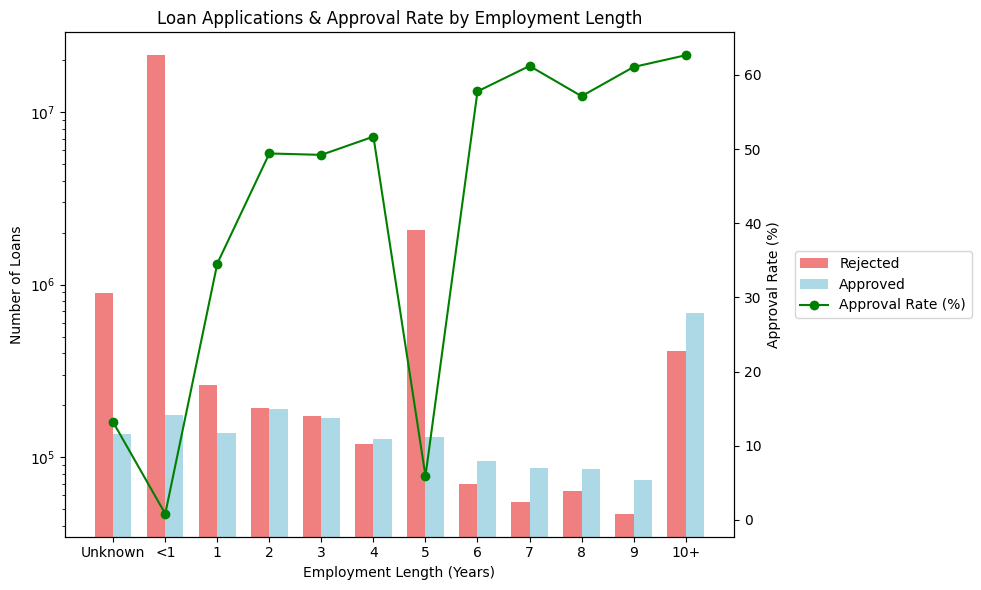

In [ ]:
all_years = pd.DataFrame({'emp_length_years': [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                          'emp_length_label': ['Unknown', '<1', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10+']})

df = all_years.merge(approval_by_emp_length, on='emp_length_years', how='left')

# Set figure size
fig, ax1 = plt.subplots(figsize=(10, 6))

x = np.arange(len(df['emp_length_label']))  # X positions for bars and line
width = 0.35  # Width of the bars

# Bar plot for Rejected
ax1.bar(
    x - width/2,
    df['0'],
    width,
    label='Rejected',
    color='lightcoral'
)

# Bar plot for Accepted
ax1.bar(
    x + width/2,
    df['1'],
    width,
    label='Approved',
    color='lightblue'
)

# Customize primary y-axis
ax1.set_xlabel('Employment Length (Years)')
ax1.set_ylabel('Number of Loans')
ax1.set_title('Loan Applications & Approval Rate by Employment Length')
ax1.set_xticks(x)
ax1.set_xticklabels(df['emp_length_label'])
ax1.set_yscale('log')  # Log scale like your Plotly chart

# Create secondary y-axis for Acceptance Rate
ax2 = ax1.twinx()

# Line plot for Acceptance Rate
ax2.plot(
    x,
    df['approval_rate'],
    color='green',
    marker='o',
    label='Approval Rate (%)'
)

ax2.set_ylabel('Approval Rate (%)')

# Combine legends from both axes
lines_labels = [ax.get_legend_handles_labels() for ax in [ax1, ax2]]
# Combine legends from both axes safely
lines = []
labels = []
for ax in [ax1, ax2]:
    handle, label = ax.get_legend_handles_labels()
    lines.extend(handle)
    labels.extend(label)


ax1.legend(lines, labels, loc='center left', bbox_to_anchor=(1.08, 0.5))

plt.tight_layout()
plt.show()


### e. Approval Rate By States

In [ ]:
# Calculate total count of loans per state
total = combined.groupBy('addr_state').count().withColumnRenamed('count', 'total_count')

# Calculate count of accepted loans per state
accepted_by_state = combined.filter(col('addr_state') != 'None') \
                               .filter(col('accepted_flag') == 1) \
                               .groupBy('addr_state', 'accepted_flag') \
                               .count().withColumnRenamed('count', 'approved_count')

# Join the two dataframes and calculate the rate
approval_rate = accepted_by_state.join(total, 'addr_state') \
                                   .withColumn('approval_rate', round((col('approved_count') / col('total_count')) * 100, 2)) \
                                   .drop('accepted_flag') \
                                   .orderBy('approval_rate') \
                                   .toPandas()
approval_rate

,addr_state,approved_count,total_count,approval_rate
0,IA,14,449,3.12
1,MS,11594,268961,4.31
2,ID,3955,79106,5.00
3,AL,25133,480273,5.23
4,AR,15831,286126,5.53
5,SC,25804,458616,5.63
6,TN,32522,567989,5.73
7,LA,23848,410520,5.81
8,KY,20127,345787,5.82
9,ME,4627,78986,5.86


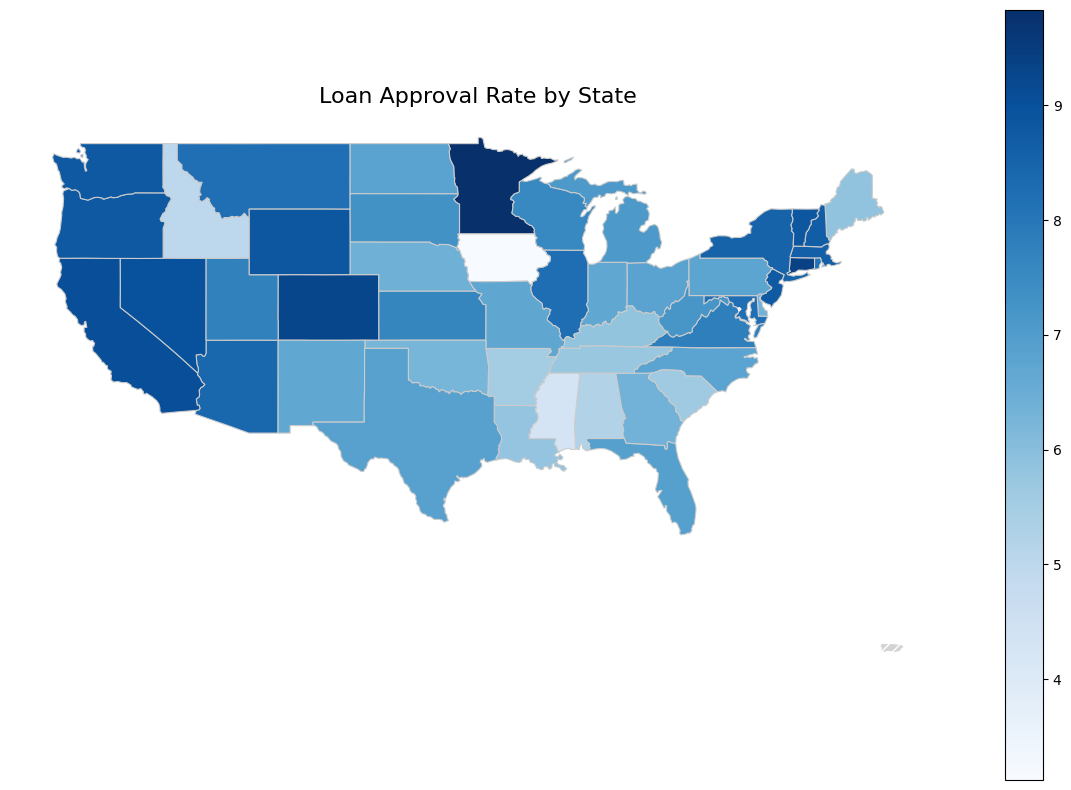

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# Load USA states GeoJSON directly from web
usa_states = gpd.read_file("https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json")

# Map state abbreviations to full state names
state_abbrev_to_name = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California', 'CO': 'Colorado',
    'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho',
    'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana',
    'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi',
    'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey',
    'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio',
    'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina',
    'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont', 'VA': 'Virginia',
    'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'
}

approval_rate['state_name'] = approval_rate['addr_state'].map(state_abbrev_to_name)
merged = usa_states.merge(approval_rate, left_on='name', right_on='state_name', how='left')
contiguous_states = merged[~merged['name'].isin(['Alaska', 'Hawaii'])]


fig, ax = plt.subplots(figsize=(12, 8))
contiguous_states.plot(
    column='approval_rate',
    cmap='Blues',
    linewidth=0.8,
    edgecolor='0.8',
    legend=True,
    ax=ax,
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "white",
        "hatch": "///",
        "label": "No Data"
    }
)

ax.set_title('Loan Approval Rate by State', fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()

## **4. Loan Quality Distribution (Grade)**

### a. Loan Quality Distribution by Grade

In [ ]:
# Loan Quality Distribution by Grade

# Define 'loan_quality'
loan_qual = accepted_df_clean.dropna(subset=['grade']) \
                         .withColumn('loan_quality',
                                     when(col('loan_status').isin("Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off",
                                                                  "Late (16-30 days)", "Late (31-120 days)", "In Grace Period"), "Bad Loan")
                                     .otherwise("Good Loan"))

# Total loans by 'grade' and 'loan_quality'
loan_by_grade = loan_qual.groupBy('grade', 'loan_quality') \
                           .agg(count('*').alias('count'))

# Total loans by 'grade'
grade_totals = loan_by_grade.groupBy('grade') \
                            .agg(sum('count').alias('total_count'))

# Percentage
loan_by_grade = loan_by_grade.join(grade_totals, on='grade') \
                             .withColumn('percentage', round(col('count') / col('total_count') * 100, 2)) \
                             .select('grade', 'loan_quality', 'count', 'total_count', 'percentage')

loan_by_grade = loan_by_grade.orderBy('grade', 'loan_quality').toPandas()
loan_by_grade

,grade,loan_quality,count,total_count,percentage
0,A,Bad Loan,15074,400364,3.77
1,A,Good Loan,385290,400364,96.23
2,B,Bad Loan,55746,617328,9.03
3,B,Good Loan,561582,617328,90.97
4,C,Bad Loan,90228,602055,14.99
5,C,Good Loan,511827,602055,85.01
6,D,Bad Loan,63147,298589,21.15
7,D,Good Loan,235442,298589,78.85
8,E,Bad Loan,35999,123869,29.06
9,E,Good Loan,87870,123869,70.94


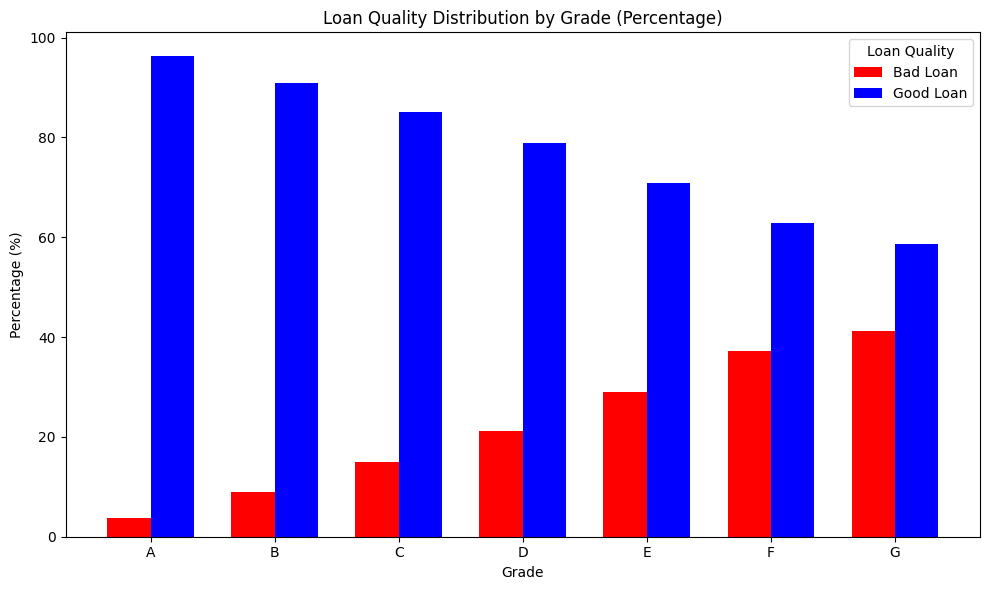

In [ ]:
# Prepare x positions
grades = loan_by_grade['grade'].unique()
x = np.arange(len(grades))
width = 0.35

# Get percentage values for each loan quality
bad_loans = loan_by_grade[loan_by_grade['loan_quality'] == 'Bad Loan']['percentage']
good_loans = loan_by_grade[loan_by_grade['loan_quality'] == 'Good Loan']['percentage']

plt.figure(figsize=(10, 6))

plt.bar(
    x - width/2,
    bad_loans,
    width,
    label='Bad Loan',
    color='red'
)

plt.bar(
    x + width/2,
    good_loans,
    width,
    label='Good Loan',
    color='blue'
)

plt.title('Loan Quality Distribution by Grade (Percentage)')
plt.xlabel('Grade')
plt.ylabel('Percentage (%)')
plt.xticks(ticks=x, labels=grades)
plt.legend(title='Loan Quality')
plt.tight_layout()
plt.show()

### b. Grade Distribution Over Time

In [ ]:
# Grade Distribution By Year

from functools import reduce
from operator import add

grade_dist = accepted_df_clean.withColumn('Year', year(col('issue_d'))) \
                              .groupBy('Year', 'grade') \
                              .count() \
                              .groupBy('Year') \
                              .pivot('grade', ['A', 'B', 'C', 'D', 'E', 'F', 'G']) \
                              .sum('count') \
                              .orderBy('Year')


grade_cols = [col(g) for g in ['A', 'B', 'C', 'D', 'E', 'F', 'G']]
grade_dist_percent = grade_dist.withColumn('total_loans', reduce(add, grade_cols))

for g in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
    grade_dist_percent = grade_dist_percent.withColumn(f'{g}_percent',
        round((col(g) / col('total_loans')) * 100, 2)
    )

grade_dist_percent = grade_dist_percent.toPandas()
grade_dist_percent

,Year,A,B,C,D,E,F,G,total_loans,A_percent,B_percent,C_percent,D_percent,E_percent,F_percent,G_percent
0,2007,65,86,129,91,90,48,32,541,12.01,15.90,23.84,16.82,16.64,8.87,5.91
1,2008,312,569,534,403,266,97,71,2252,13.85,25.27,23.71,17.90,11.81,4.31,3.15
2,2009,1166,1407,1302,774,288,94,49,5080,22.95,27.70,25.63,15.24,5.67,1.85,0.96
3,2010,2739,3562,2654,1803,901,283,114,12056,22.72,29.55,22.01,14.96,7.47,2.35,0.95
4,2011,5616,6423,3826,2698,1650,661,172,21046,26.68,30.52,18.18,12.82,7.84,3.14,0.82
5,2012,10597,18056,11423,6999,2928,1187,186,51376,20.63,35.14,22.23,13.62,5.70,2.31,0.36
6,2013,16700,41989,36341,19456,8530,4103,791,127910,13.06,32.83,28.41,15.21,6.67,3.21,0.62
7,2014,33377,57529,61725,39763,18465,5697,1525,218081,15.30,26.38,28.30,18.23,8.47,2.61,0.70
8,2015,67133,108686,110991,57165,31574,8837,1959,386345,17.38,28.13,28.73,14.80,8.17,2.29,0.51
9,2016,65352,124905,121872,53996,23467,8404,2320,400316,16.33,31.20,30.44,13.49,5.86,2.10,0.58


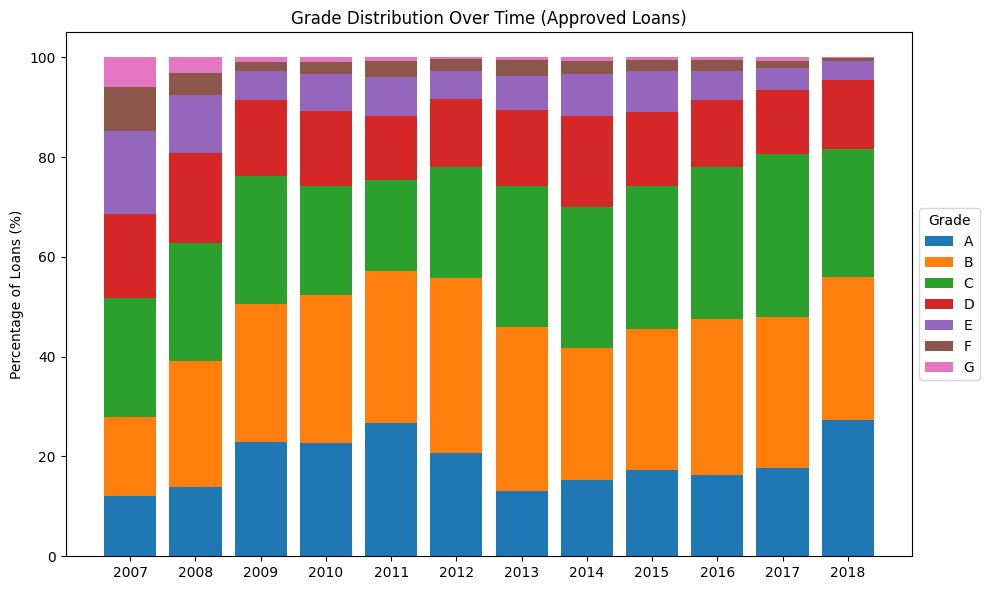

In [ ]:
# Prepare x positions for each year
years = grade_dist_percent['Year'].values
x = np.arange(len(years))

grades = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
grade_cols = [f'{g}_percent' for g in grades]

plt.figure(figsize=(10, 6))
bottom = np.zeros(len(years))

for grade in grades:
    plt.bar(
        x,
        grade_dist_percent[f'{grade}_percent'],
        bottom=bottom,
        label=grade
    )
    bottom += grade_dist_percent[f'{grade}_percent'].values

plt.title('Grade Distribution Over Time (Approved Loans)')
plt.ylabel('Percentage of Loans (%)')
plt.xticks(ticks=x, labels=years)
plt.legend(title='Grade', loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

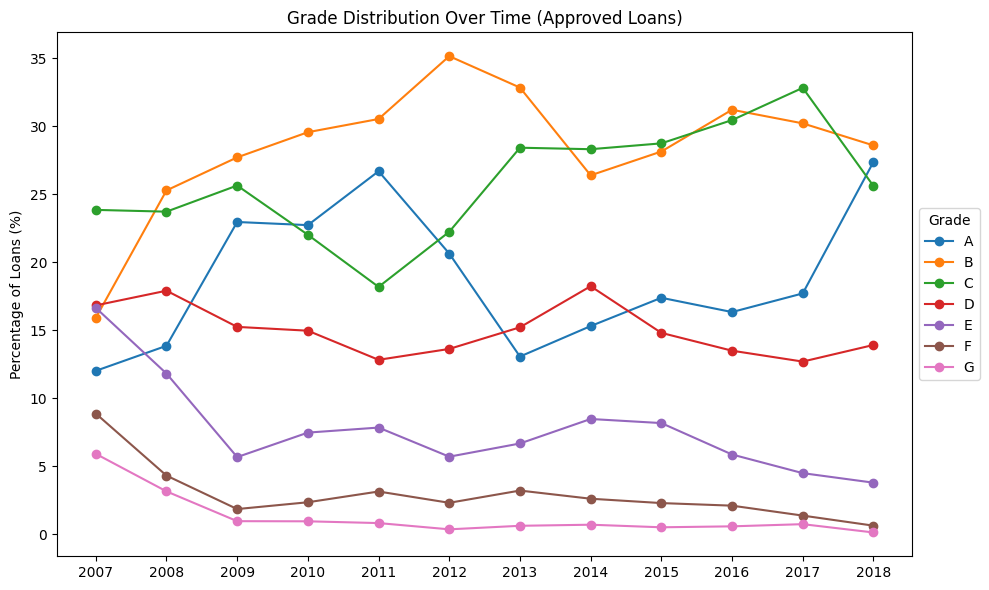

In [ ]:
# Prepare x-axis
years = grade_dist_percent['Year'].values
grades = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
grade_cols = [f'{g}_percent' for g in grades]

plt.figure(figsize=(10, 6))

for grade in grades:
    plt.plot(
        years,
        grade_dist_percent[f'{grade}_percent'],
        marker='o',
        linestyle='-',
        label=grade
    )

plt.title('Grade Distribution Over Time (Approved Loans)')
plt.ylabel('Percentage of Loans (%)')
plt.xticks(ticks=years, labels=years)
plt.legend(title='Grade', loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

### c. Median Interest Rate by Grade

In [ ]:
# Median Interest Rate by Grade

med_int_rate_gr = accepted_df_clean.groupBy('Grade') \
                            .agg(median('int_rate')) \
                            .orderBy('Grade') \
                            .toPandas()
med_int_rate_gr

,Grade,median(int_rate)
0,A,7.24
1,B,10.75
2,C,13.99
3,D,17.99
4,E,21.48
5,F,24.50
6,G,28.18


### d. Median Interest Rate by Grade Over Time

In [ ]:
# Median Interest Rate by Grade Over Time

grade_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

int_rate_by_grade = accepted_df_clean.withColumn('Year', year(col('issue_d'))) \
                              .groupBy('Year', 'grade') \
                              .agg(median('int_rate').alias('median_int_rate')) \
                              .groupBy('Year') \
                              .pivot('grade',  ['A', 'B', 'C', 'D', 'E', 'F', 'G']) \
                              .agg(first('median_int_rate')) \
                              .orderBy('Year').toPandas()
int_rate_by_grade

,Year,A,B,C,D,E,F,G
0,2007,7.75,9.33,10.91,12.49,14.07,15.49,17.54
1,2008,8.32,10.39,11.78,13.30,14.82,16.15,18.04
2,2009,8.94,11.83,13.22,14.96,16.35,18.21,19.82
3,2010,7.14,10.75,13.48,15.21,16.82,18.67,20.53
4,2011,7.29,10.99,13.49,16.49,18.64,20.62,22.11
5,2012,7.90,12.12,15.31,18.49,21.00,23.26,24.70
6,2013,7.90,11.99,15.61,18.55,21.60,23.76,25.80
7,2014,7.69,11.44,14.16,16.99,20.20,24.08,25.83
8,2015,6.92,9.99,13.33,16.99,18.99,23.99,26.77
9,2016,7.24,10.49,13.67,17.99,22.39,25.69,28.67


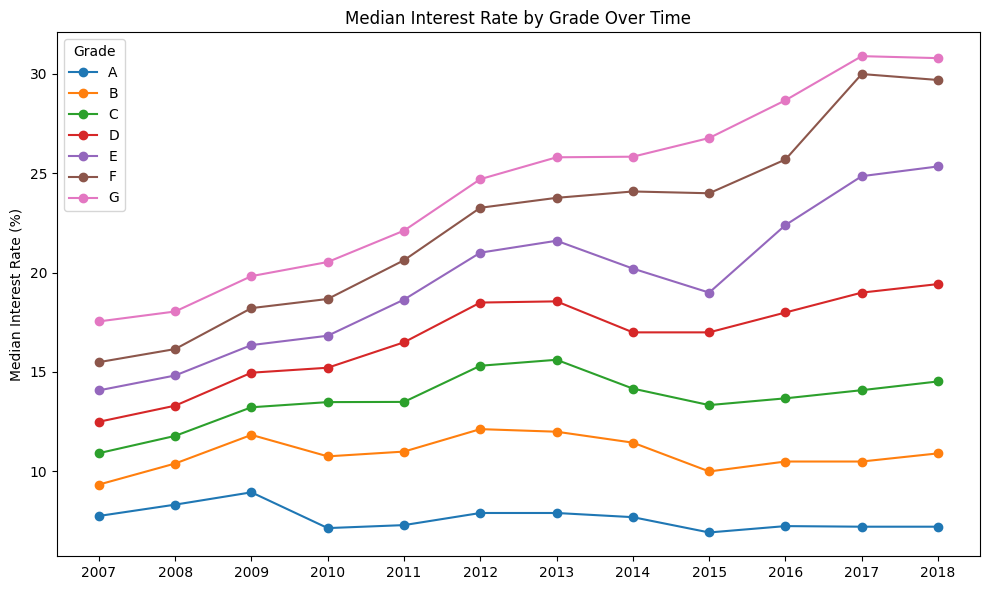

In [ ]:
# Prepare x-axis
years = int_rate_by_grade['Year'].values
grades = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

plt.figure(figsize=(10, 6))

# Plot each grade as a separate line
for grade in grades:
    plt.plot(
        years,
        int_rate_by_grade[grade],
        marker='o',
        linestyle='-',
        label=grade
    )

plt.title('Median Interest Rate by Grade Over Time')
plt.ylabel('Median Interest Rate (%)')
plt.xticks(ticks=years, labels=years)
plt.legend(title='Grade', loc='upper left')
# plt.legend(title='Grade', loc='upper left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

### e. Loan Purpose Over Time

In [ ]:
# Loan Purpose Over Time

purpose = accepted_df_clean.withColumn('Year', year(col('issue_d'))) \
                              .groupBy('Year', 'purpose') \
                              .count() \
                              .groupBy('Year') \
                              .pivot('purpose') \
                              .sum('count') \
                              .orderBy('Year').toPandas()

purpose

,Year,car,credit_card,debt_consolidation,educational,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding
0,2007,12,79,195,36.0,35,7,10,8,14,81,NaN,51,4,9
1,2008,52,369,921,80.0,130,26,87,46,30,320,3.0,120,14,54
2,2009,189,601,2106,180.0,370,70,251,86,66,633,5.0,354,25,144
3,2010,401,1472,5503,113.0,915,101,843,214,205,1398,36.0,448,121,286
4,2011,912,2745,10306,NaN,1614,209,1054,369,295,1823,56.0,947,221,495
5,2012,880,10063,29598,NaN,2750,392,1308,603,386,2941,69.0,1342,329,715
6,2013,1010,31203,76371,NaN,6957,640,2187,838,617,5624,50.0,1298,543,572
7,2014,1737,51375,131954,NaN,12089,696,3623,2186,1238,9780,116.0,2165,1115,7
8,2015,3287,93399,228763,NaN,23172,1338,7008,3655,2229,18000,214.0,3175,2102,3
9,2016,4546,83877,229032,NaN,28717,1864,9755,5037,3017,26649,286.0,4517,3018,1


## **5. Average Financial Health Indicators of Approved Loans**

### a. Average Fico Range Overtime

In [ ]:
# Average Fico Range Overtime

avg_fico = accepted_df_clean.withColumn('Year', year(col('issue_d'))) \
                            .groupBy('Year') \
                            .agg(round(avg('fico_range_low'), 0).alias('avg_fico_range_low'),
                                 round(avg('fico_range_high'), 0).alias('avg_fico_range_high')) \
                            .orderBy('Year') \
                            .toPandas()

avg_fico

,Year,avg_fico_range_low,avg_fico_range_high
0,2007,689.0,693.0
1,2008,697.0,701.0
2,2009,715.0,719.0
3,2010,713.0,717.0
4,2011,715.0,719.0
5,2012,701.0,705.0
6,2013,695.0,699.0
7,2014,693.0,697.0
8,2015,694.0,698.0
9,2016,695.0,699.0


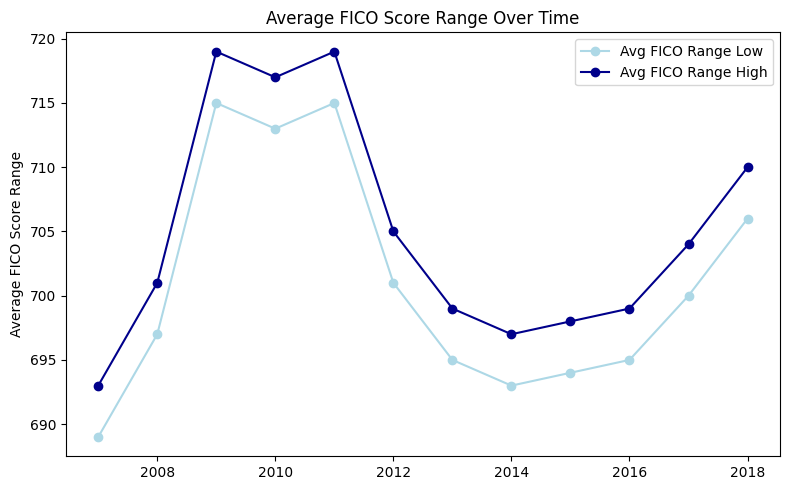

In [ ]:
plt.figure(figsize=(8, 5))

plt.plot(
    avg_fico['Year'],
    avg_fico['avg_fico_range_low'],
    color='lightblue',
    linestyle='-',
    marker='o',
    label='Avg FICO Range Low'
)

plt.plot(
    avg_fico['Year'],
    avg_fico['avg_fico_range_high'],
    color='darkblue',
    linestyle='-',
    marker='o',
    label='Avg FICO Range High'
)

plt.title('Average FICO Score Range Over Time')
plt.ylabel('Average FICO Score Range')
plt.legend()
plt.tight_layout()
plt.show()

### b. Avergae Debt-to-Income Over Time

In [ ]:
# Avergae Debt-to-Income Over Time

avg_dti = accepted_df_clean.withColumn('Year', year(col('issue_d'))) \
                            .groupBy('Year') \
                            .agg(round(avg('dti'), 0).alias('avg_dti')) \
                            .orderBy('Year') \
                            .toPandas()
avg_dti

,Year,avg_dti
0,2007,11.0
1,2008,13.0
2,2009,12.0
3,2010,13.0
4,2011,14.0
5,2012,17.0
6,2013,17.0
7,2014,18.0
8,2015,19.0
9,2016,18.0


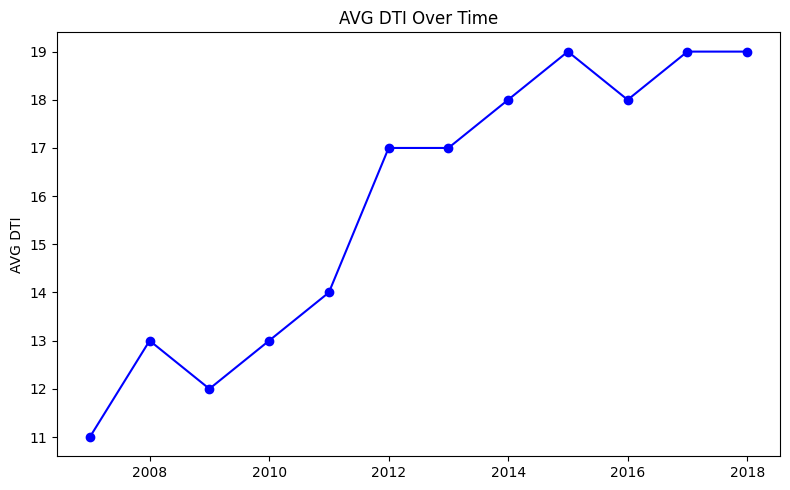

In [ ]:
plt.figure(figsize=(8, 5))

plt.plot(
    avg_dti['Year'],
    avg_dti['avg_dti'],
    marker='o',
    linestyle='-',
    color='blue'
)

plt.title('AVG DTI Over Time')
plt.ylabel('AVG DTI')
plt.tight_layout()
plt.show()

### c. Average Months of Credit Over Time

In [ ]:
# Average Months of Credit Over Time

avg_moc = accepted_df_clean.withColumn('Year', year(col('issue_d'))) \
                            .groupBy('Year') \
                            .agg(round(avg('months_of_credit'), 0).alias('avg_months_of_credit')) \
                            .orderBy('Year') \
                            .toPandas()
avg_moc

,Year,avg_months_of_credit
0,2007,115.0
1,2008,141.0
2,2009,153.0
3,2010,160.0
4,2011,170.0
5,2012,174.0
6,2013,189.0
7,2014,197.0
8,2015,199.0
9,2016,198.0


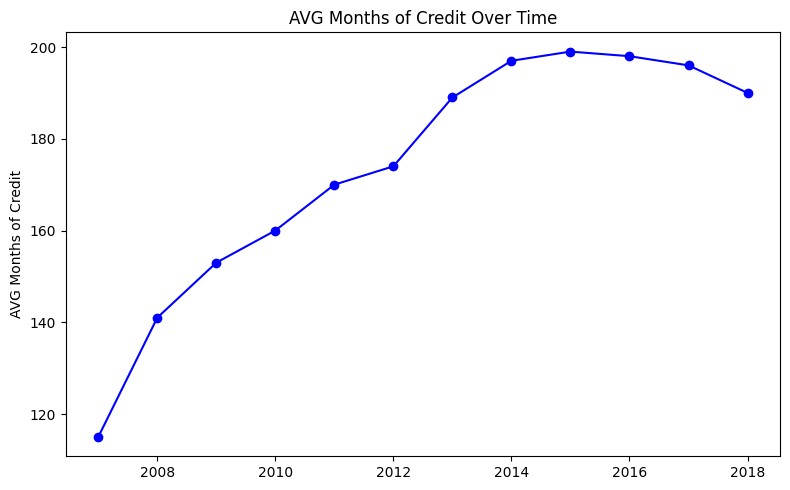

In [ ]:
plt.figure(figsize=(8, 5))

plt.plot(
    avg_moc['Year'],
    avg_moc['avg_months_of_credit'],
    marker='o',
    linestyle='-',
    color='blue'
)

plt.title('AVG Months of Credit Over Time')
plt.ylabel('AVG Months of Credit')
plt.tight_layout()
plt.show()

### d. Average Annual Income Over Time

In [ ]:
# Average Annual Income Over Time

avg_annual_inc = accepted_df_clean.withColumn('Year', year(col('issue_d'))) \
                            .withColumn('annual_income', when((col('application_type') == 'Individual'), col('annual_inc')).otherwise('annual_inc_joint')) \
                            .groupBy('Year') \
                            .agg(round(avg('annual_income'), 0).alias('avg_annual_income')) \
                            .orderBy('Year') \
                            .toPandas()
avg_annual_inc

,Year,avg_annual_income
0,2007,63038.0
1,2008,63357.0
2,2009,67839.0
3,2010,68343.0
4,2011,68562.0
5,2012,68818.0
6,2013,72079.0
7,2014,73409.0
8,2015,75429.0
9,2016,78149.0


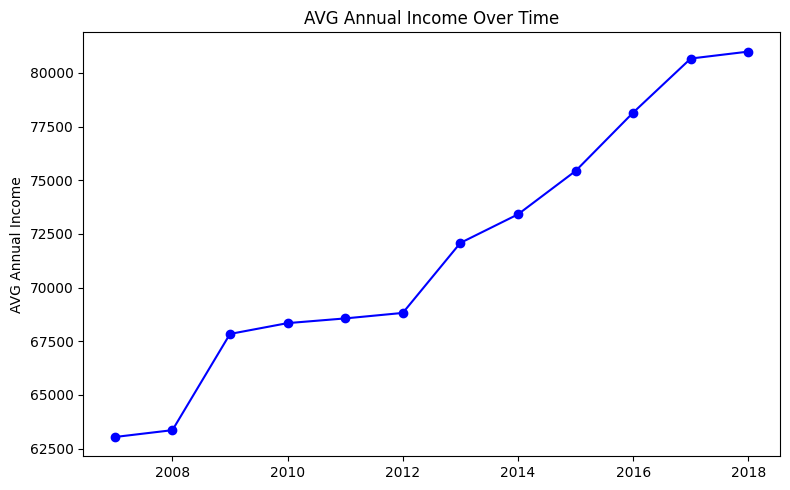

In [ ]:
plt.figure(figsize=(8, 5))

plt.plot(
    avg_annual_inc['Year'],
    avg_annual_inc['avg_annual_income'],
    marker='o',
    linestyle='-',
    color='blue'
)

plt.title('AVG Annual Income Over Time')
plt.ylabel('AVG Annual Income')
plt.tight_layout()
plt.show()

## **6. Loss Rate By Grade Over Time**

In [ ]:
# CO rate by Grade

CO_rate_loan_count = accepted_df_clean \
                                      .withColumn('CO_flag', when(col('loan_status').isin(['Charged Off', 'Does not meet the credit policy. Status:Charged Off']), 1).otherwise(0)) \
                                      .groupBy('grade') \
                                      .agg(
                                          spark_sum('CO_flag').alias('CO_count'),
                                          count('*').alias('total_loans')
                                      ) \
                                      .withColumn('CO_rate', round((col('CO_count') / col('total_loans')) * 100, 2)) \
                                      .orderBy('grade').show()

+-----+--------+-----------+-------+
|grade|CO_count|total_loans|CO_rate|
+-----+--------+-----------+-------+
|    A|   12966|     400364|   3.24|
|    B|   48772|     617328|    7.9|
|    C|   79159|     602055|  13.15|
|    D|   56176|     298589|  18.81|
|    E|   32947|     123869|   26.6|
|    F|   13168|      37912|  34.73|
|    G|    4161|      10875|  38.26|
+-----+--------+-----------+-------+



In [ ]:
# CO rate by Grade Over Time

from pyspark.sql.functions import col, year, when, sum as spark_sum, count, round
from functools import reduce
from operator import add

grade_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

CO_rate_loan_count = accepted_df_clean.withColumn('Year', year(col('issue_d'))) \
    .withColumn('CO_flag', when(col('loan_status').isin(['Charged Off', 'Does not meet the credit policy. Status:Charged Off']), 1).otherwise(0)) \
    .groupBy('Year', 'grade') \
    .agg(
        count('*').alias('issued_count'),
        spark_sum('CO_flag').alias('CO_count')
    ) \
    .groupBy('Year') \
    .pivot('grade', grade_list) \
    .agg(
        spark_sum('issued_count').alias('issued_count'),
        spark_sum('CO_count').alias('CO_count')
    ) \
    .orderBy('Year')

issued_cols = [col(f'{g}_issued_count') for g in grade_list]

CO_rate_loan_count = CO_rate_loan_count.withColumn(
    'total_loans',
    reduce(add, issued_cols)
)

for g in grade_list:
    CO_rate_loan_count = CO_rate_loan_count.withColumn(
        f'{g}_CO_rate',
        round((col(f'{g}_CO_count') / col(f'{g}_issued_count')) * 100, 2)
    )

for g in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
    CO_rate_loan_count = CO_rate_loan_count.withColumnRenamed(f'{g}_issued_count', f'{g}_count') \
                                     .withColumnRenamed(f'{g}_CO_count', f'{g}_CO_count') \
                                     .withColumnRenamed(f'{g}_CO_rate', f'{g}_CO_rate')

CO_rate_loan_count.show()

+----+-------+----------+-------+----------+-------+----------+-------+----------+-------+----------+-------+----------+-------+----------+-----------+---------+---------+---------+---------+---------+---------+---------+
|Year|A_count|A_CO_count|B_count|B_CO_count|C_count|C_CO_count|D_count|D_CO_count|E_count|E_CO_count|F_count|F_CO_count|G_count|G_CO_count|total_loans|A_CO_rate|B_CO_rate|C_CO_rate|D_CO_rate|E_CO_rate|F_CO_rate|G_CO_rate|
+----+-------+----------+-------+----------+-------+----------+-------+----------+-------+----------+-------+----------+-------+----------+-----------+---------+---------+---------+---------+---------+---------+---------+
|2007|     65|         3|     86|        13|    129|        31|     91|        27|     90|        26|     48|        23|     32|        16|        541|     4.62|    15.12|    24.03|    29.67|    28.89|    47.92|     50.0|
|2008|    312|        19|    569|        95|    534|       109|    403|       109|    266|        71|     97|   

In [ ]:
# CO rate by Grade & Year

from pyspark.sql.functions import col, year, when, sum as spark_sum, round

output3_year_grade = accepted_df_clean.withColumn('Year', year(col('issue_d'))) \
                                      .withColumn('CO_flag', when(col('loan_status').isin(['Charged Off', 'Does not meet the credit policy. Status:Charged Off']), 1).otherwise(0)) \
                                      .groupBy('Year', 'grade') \
                                      .agg(
                                          count('*').alias('count'),
                                          spark_sum('CO_flag').alias('CO_count')) \
                                      .withColumn(
                                          'CO_rate',
                                          round((col('CO_count') / col('count')) * 100, 2)) \
                                      .orderBy('Year', 'grade')


from pyspark.sql.functions import first

pivoted_output3 = output3_year_grade.groupBy('Year') \
    .pivot('grade', ['A', 'B', 'C', 'D', 'E', 'F', 'G']) \
    .agg(
        first('count').alias('count'),
        first('CO_count').alias('CO_count'),
        first('CO_rate').alias('CO_rate')
    ) \
    .orderBy('Year')

for g in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
    pivoted_output_CO = pivoted_output3.withColumnRenamed(f'{g}_issued_count', f'{g}_count') \
                                     .withColumnRenamed(f'{g}_CO_count', f'{g}_CO_count') \
                                     .withColumnRenamed(f'{g}_CO_rate', f'{g}_CO_rate')

pivoted_output_CO.show()


CO_rate_year = pivoted_output_CO.select('Year', 'A_CO_rate', 'B_CO_rate', 'C_CO_rate', 'D_CO_rate', 'E_CO_rate', 'F_CO_rate', 'G_CO_rate').show()

+----+-------+----------+---------+-------+----------+---------+-------+----------+---------+-------+----------+---------+-------+----------+---------+-------+----------+---------+-------+----------+---------+
|Year|A_count|A_CO_count|A_CO_rate|B_count|B_CO_count|B_CO_rate|C_count|C_CO_count|C_CO_rate|D_count|D_CO_count|D_CO_rate|E_count|E_CO_count|E_CO_rate|F_count|F_CO_count|F_CO_rate|G_count|G_CO_count|G_CO_rate|
+----+-------+----------+---------+-------+----------+---------+-------+----------+---------+-------+----------+---------+-------+----------+---------+-------+----------+---------+-------+----------+---------+
|2007|     65|         3|     4.62|     86|        13|    15.12|    129|        31|    24.03|     91|        27|    29.67|     90|        26|    28.89|     48|        23|    47.92|     32|        16|     50.0|
|2008|    312|        19|     6.09|    569|        95|     16.7|    534|       109|    20.41|    403|       109|    27.05|    266|        71|    26.69|     97| 

In [ ]:
# CO Dollar Amount by Grade

from pyspark.sql.functions import col, when, sum as spark_sum, round

grade_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

output2_by_grade = accepted_df_clean.withColumn(
    'CO_flag',
    when(col('loan_status').isin(['Charged Off', 'Does not meet the credit policy. Status:Charged Off']), 1).otherwise(0)
).groupBy('grade') \
.agg(
    spark_sum('loan_amnt').alias('total_loan_amount'),
    spark_sum(when(col('CO_flag') == 1, col('loan_amnt')).otherwise(0)).alias('CO_loan_amount')
) \
.withColumn(
    'CO_loss_rate',
    round((col('CO_loan_amount') / col('total_loan_amount')) * 100, 2)
) \
.orderBy('grade')

output2_by_grade.show()

+-----+-----------------+--------------+------------+
|grade|total_loan_amount|CO_loan_amount|CO_loss_rate|
+-----+-----------------+--------------+------------+
|    A|     5.76710665E9|   1.7581595E8|        3.05|
|    B|     8.62496715E9|  6.50891225E8|        7.55|
|    C|    8.933616275E9|   1.1514922E9|       12.89|
|    D|     4.62757755E9|    8.859066E8|       19.14|
|    E|    2.131548225E9|  5.89134925E8|       27.64|
|    F|     7.15444925E8|  2.54076925E8|       35.51|
|    G|       2.184004E8|   8.3912725E7|       38.42|
+-----+-----------------+--------------+------------+



In [ ]:
# CO Dollar Amount by Year

output2_by_year = accepted_df_clean.withColumn(
    'Year',
    year(col('issue_d'))
).withColumn(
    'CO_flag',
    when(col('loan_status').isin(['Charged Off', 'Does not meet the credit policy. Status:Charged Off']), 1).otherwise(0)
).groupBy('Year') \
.agg(
    spark_sum('loan_amnt').alias('total_loan_amount'),
    spark_sum(when(col('CO_flag') == 1, col('loan_amnt')).otherwise(0)).alias('CO_loan_amount')
) \
.withColumn(
    'CO_loss_rate',
    round((col('CO_loan_amount') / col('total_loan_amount')) * 100, 2)
) \
.orderBy('Year')

output2_by_year.show()

+----+-----------------+--------------+------------+
|Year|total_loan_amount|CO_loan_amount|CO_loss_rate|
+----+-----------------+--------------+------------+
|2007|        4504900.0|     1305175.0|       28.97|
|2008|      1.9652775E7|     4516300.0|       22.98|
|2009|      4.9565075E7|     7299925.0|       14.73|
|2010|     1.25998925E8|   1.7784025E7|       14.11|
|2011|      2.5195005E8|     4.19539E7|       16.65|
|2012|     6.86561825E8|   1.2171245E8|       17.73|
|2013|      1.8650841E9|    3.090948E8|       16.57|
|2014|     3.20251435E9|   5.8069485E8|       18.13|
|2015|    5.805046625E9|   1.0629931E9|       18.31|
|2016|     5.81142095E9|  9.43638875E8|       16.24|
|2017|    5.995277525E9|   5.6133475E8|        9.36|
|2018|    7.201084075E9|    1.389024E8|        1.93|
+----+-----------------+--------------+------------+



In [ ]:
# CO Dollar Amount by Grade & Year

from pyspark.sql.functions import col, year, when, sum as spark_sum, round

output3_year_grade = accepted_df_clean.withColumn('Year', year(col('issue_d'))) \
                                      .withColumn('CO_flag', when(col('loan_status').isin(['Charged Off', 'Does not meet the credit policy. Status:Charged Off']), 1).otherwise(0)) \
                                      .groupBy('Year', 'grade') \
                                      .agg(
                                          spark_sum('loan_amnt').alias('total_loan_amount'),
                                          spark_sum(when(col('CO_flag') == 1, col('loan_amnt')).otherwise(0)).alias('CO_loan_amount')) \
                                      .withColumn(
                                          'CO_loss_rate',
                                          round((col('CO_loan_amount') / col('total_loan_amount')) * 100, 2)) \
                                      .orderBy('Year', 'grade')


from pyspark.sql.functions import first

pivoted_output3 = output3_year_grade.groupBy('Year') \
    .pivot('grade', ['A', 'B', 'C', 'D', 'E', 'F', 'G']) \
    .agg(
        first('total_loan_amount').alias('total_loan_amount'),
        first('CO_loan_amount').alias('CO_loan_amount'),
        first('CO_loss_rate').alias('CO_loss_rate')
    ) \
    .orderBy('Year')

for g in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
    pivoted_output3 = pivoted_output3.withColumnRenamed(f'{g}_total_loan_amount', f'{g}_total_amt') \
                                     .withColumnRenamed(f'{g}_CO_loan_amount', f'{g}_CO_amt') \
                                     .withColumnRenamed(f'{g}_CO_loss_rate', f'{g}_CO_rate')

pivoted_output3.show()

CO_Dollar_Grade_Year = pivoted_output3.select('Year', 'A_CO_rate', 'B_CO_rate', 'C_CO_rate', 'D_CO_rate', 'E_CO_rate', 'F_CO_rate', 'G_CO_rate').show()

+----+-------------+-----------+---------+-------------+------------+---------+-------------+------------+---------+------------+------------+---------+------------+------------+---------+------------+-----------+---------+-----------+-----------+---------+
|Year|  A_total_amt|   A_CO_amt|A_CO_rate|  B_total_amt|    B_CO_amt|B_CO_rate|  C_total_amt|    C_CO_amt|C_CO_rate| D_total_amt|    D_CO_amt|D_CO_rate| E_total_amt|    E_CO_amt|E_CO_rate| F_total_amt|   F_CO_amt|F_CO_rate|G_total_amt|   G_CO_amt|G_CO_rate|
+----+-------------+-----------+---------+-------------+------------+---------+-------------+------------+---------+------------+------------+---------+------------+------------+---------+------------+-----------+---------+-----------+-----------+---------+
|2007|     328550.0|     7500.0|     2.28|     778275.0|    131500.0|     16.9|    1067975.0|    265575.0|    24.87|    715225.0|    211900.0|    29.63|    717000.0|    214250.0|    29.88|    565300.0|   291375.0|    51.54|   